In [1]:
%reload_ext autoreload
%autoreload 2

import os
from pathlib import Path
import multiprocessing

import jax
import jax.numpy as jnp
import pandas as pd
import numpy as np
import numpyro
import numpyro.distributions as dist

from hbmep.config import Config
from hbmep.model import Baseline
from hbmep.model.utils import Site as site
from hbmep.utils.constants import RECTIFIED_LOGISTIC

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()


#### Load config

In [2]:
root_path = Path(os.getcwd()).parent.parent.parent.absolute()
toml_path = os.path.join(root_path, "configs/simulation.toml")

config = Config(toml_path=toml_path)


2023-07-18 14:32:18,169 - hbmep.config - INFO - Verifying configuration ...
2023-07-18 14:32:18,169 - hbmep.config - INFO - Success!


#### Load data and preprocess

In [3]:
# class RectifiedLogistic(Baseline):
#     def __init__(self, config: Config):
#         super(RectifiedLogistic, self).__init__(config=config)
#         self.link = RECTIFIED_LOGISTIC

#     def _model(self, subject, features, intensity, response_obs=None):
#         intensity = intensity.reshape(-1, 1)
#         intensity = np.tile(intensity, (1, self.n_response))

#         feature0 = features[0].reshape(-1,)

#         n_data = intensity.shape[0]
#         n_subject = np.unique(subject).shape[0]
#         n_feature0 = np.unique(feature0).shape[0]

#         with numpyro.plate(site.n_response, self.n_response, dim=-1):
#             with numpyro.plate(site.n_subject, n_subject, dim=-2):
#                 """ Hyper-priors """
#                 mu_a = numpyro.sample(
#                     site.mu_a,
#                     dist.TruncatedNormal(100, 100, low=0)
#                 )
#                 sigma_a = numpyro.sample(site.sigma_a, dist.HalfCauchy(20))

#                 sigma_b = numpyro.sample(site.sigma_b, dist.HalfCauchy(0.5))

#                 sigma_L = numpyro.sample(site.sigma_L, dist.HalfCauchy(0.05))
#                 sigma_H = numpyro.sample(site.sigma_H, dist.HalfCauchy(5))
#                 sigma_v = numpyro.sample(site.sigma_v, dist.HalfCauchy(5))

#                 with numpyro.plate("n_feature0", n_feature0, dim=-3):
#                     """ Priors """
#                     a = numpyro.sample(
#                         site.a,
#                         dist.TruncatedNormal(mu_a, sigma_a, low=0)
#                     )
#                     b = numpyro.sample(site.b, dist.HalfNormal(sigma_b))

#                     L = numpyro.sample(site.L, dist.HalfNormal(sigma_L))
#                     H = numpyro.sample(site.H, dist.HalfNormal(sigma_H))
#                     v = numpyro.sample(site.v, dist.HalfNormal(sigma_v))

#                     p = numpyro.sample(site.p, dist.HalfNormal(10))

#                     g_1 = numpyro.sample(
#                         site.g_1, dist.HalfCauchy(20)
#                     )
#                     g_2 = numpyro.sample(
#                         site.g_2, dist.HalfCauchy(20)
#                     )

#         """ Model """
#         mu = numpyro.deterministic(
#             site.mu,
#             L[feature0, subject]
#             + jnp.maximum(
#                 0,
#                 -1
#                 + (H[feature0, subject] + 1)
#                 / jnp.power(
#                     1
#                     + (jnp.power(1 + H[feature0, subject], v[feature0, subject]) - 1)
#                     * jnp.exp(-b[feature0, subject] * (intensity - a[feature0, subject])),
#                     1 / v[feature0, subject]
#                 )
#             )
#         )
#         beta = numpyro.deterministic(
#             site.beta,
#             g_1[feature0, subject]
#             + g_2[feature0, subject] * jnp.power(1 / mu, p[feature0, subject])
#         )

#         with numpyro.plate(site.data, n_data):
#             return numpyro.sample(
#                 site.obs,
#                 dist.Gamma(mu * beta, beta).to_event(1),
#                 obs=response_obs
#             )


# model = RectifiedLogistic(config=config)

In [4]:
# class RectifiedLogistic(Baseline):
#     def __init__(self, config: Config):
#         super(RectifiedLogistic, self).__init__(config=config)
#         self.link = RECTIFIED_LOGISTIC

#         self.mu_a = config.PRIORS[site.mu_a]
#         self.sigma_a = config.PRIORS[site.sigma_a]

#         self.sigma_b = config.PRIORS[site.sigma_b]

#         self.sigma_L = config.PRIORS[site.sigma_L]
#         self.sigma_H = config.PRIORS[site.sigma_H]
#         self.sigma_v = config.PRIORS[site.sigma_v]

#         self.g_1 = config.PRIORS[site.g_1]
#         self.g_2 = config.PRIORS[site.g_2]

#         self.p = config.PRIORS[site.p]

#     def _model(self, subject, features, intensity, response_obs=None):
#         intensity = intensity.reshape(-1, 1)
#         intensity = np.tile(intensity, (1, self.n_response))

#         feature0 = features[0].reshape(-1,)

#         n_data = intensity.shape[0]
#         n_subject = np.unique(subject).shape[0]
#         n_feature0 = np.unique(feature0).shape[0]

#         with numpyro.plate(site.n_response, self.n_response, dim=-1):
#             with numpyro.plate(site.n_subject, n_subject, dim=-2):
#                 """ Hyper-priors """
#                 mu_a = numpyro.sample(
#                     site.mu_a,
#                     dist.TruncatedNormal(150, 20, low=0)
#                 )
#                 sigma_a = numpyro.sample(site.sigma_a, dist.HalfNormal(20))

#                 sigma_b = numpyro.sample(site.sigma_b, dist.HalfNormal(0.1))

#                 sigma_L = numpyro.sample(site.sigma_L, dist.HalfNormal(0.05))
#                 sigma_H = numpyro.sample(site.sigma_H, dist.HalfNormal(5))
#                 sigma_v = numpyro.sample(site.sigma_v, dist.HalfNormal(5))

#                 with numpyro.plate("n_feature0", n_feature0, dim=-3):
#                     """ Priors """
#                     a = numpyro.sample(
#                         site.a,
#                         dist.TruncatedNormal(mu_a, sigma_a, low=0)
#                     )
#                     b = numpyro.sample(site.b, dist.HalfNormal(sigma_b))

#                     L = numpyro.sample(site.L, dist.HalfNormal(sigma_L))
#                     H = numpyro.sample(site.H, dist.HalfNormal(sigma_H))
#                     v = numpyro.sample(site.v, dist.HalfNormal(sigma_v))

#                     g_1 = numpyro.sample(
#                         site.g_1, dist.HalfCauchy(20)
#                     )
#                     g_2 = numpyro.sample(
#                         site.g_2, dist.HalfCauchy(20)
#                     )

#                     p = numpyro.sample(site.p, dist.HalfCauchy(10))

#         """ Model """
#         mu = numpyro.deterministic(
#             site.mu,
#             L[feature0, subject]
#             + jnp.maximum(
#                 0,
#                 -1
#                 + (H[feature0, subject] + 1)
#                 / jnp.power(
#                     1
#                     + (jnp.power(1 + H[feature0, subject], v[feature0, subject]) - 1)
#                     * jnp.exp(-b[feature0, subject] * (intensity - a[feature0, subject])),
#                     1 / v[feature0, subject]
#                 )
#             )
#         )
#         beta = numpyro.deterministic(
#             site.beta,
#             g_1[feature0, subject]
#             + g_2[feature0, subject] * (1 / (mu + 1 + p[feature0, subject]))
#         )

#         with numpyro.plate(site.data, n_data):
#             return numpyro.sample(
#                 site.obs,
#                 dist.Gamma(mu * beta, beta).to_event(1),
#                 obs=response_obs
#             )


# model = RectifiedLogistic(config=config)

In [5]:
class RectifiedLogistic(Baseline):
    def __init__(self, config: Config):
        super(RectifiedLogistic, self).__init__(config=config)
        self.link = RECTIFIED_LOGISTIC

        self.mu_a = config.PRIORS[site.mu_a]
        self.sigma_a = config.PRIORS[site.sigma_a]

        self.sigma_b = config.PRIORS[site.sigma_b]

        self.sigma_L = config.PRIORS[site.sigma_L]
        self.sigma_H = config.PRIORS[site.sigma_H]
        self.sigma_v = config.PRIORS[site.sigma_v]

        self.g_1 = config.PRIORS[site.g_1]
        self.g_2 = config.PRIORS[site.g_2]

        self.p = config.PRIORS[site.p]

    def _model(self, subject, features, intensity, response_obs=None):
        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)

        n_data = intensity.shape[0]
        n_subject = np.unique(subject).shape[0]
        n_feature0 = np.unique(feature0).shape[0]

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate(site.n_subject, n_subject, dim=-2):
                """ Hyper-priors """
                mu_a = numpyro.sample(
                    site.mu_a,
                    dist.TruncatedNormal(150, 20, low=0)
                )
                sigma_a = numpyro.sample(site.sigma_a, dist.HalfNormal(20))

                sigma_b = numpyro.sample(site.sigma_b, dist.HalfNormal(0.1))

                sigma_L = numpyro.sample(site.sigma_L, dist.HalfNormal(0.05))
                sigma_H = numpyro.sample(site.sigma_H, dist.HalfNormal(5))
                sigma_v = numpyro.sample(site.sigma_v, dist.HalfNormal(5))

                with numpyro.plate("n_feature0", n_feature0, dim=-3):
                    """ Priors """
                    a = numpyro.sample(
                        site.a,
                        dist.TruncatedNormal(mu_a, sigma_a, low=0)
                    )
                    b = numpyro.sample(site.b, dist.HalfNormal(sigma_b))

                    L = numpyro.sample(site.L, dist.HalfNormal(sigma_L))
                    H = numpyro.sample(site.H, dist.HalfNormal(sigma_H))
                    v = numpyro.sample(site.v, dist.HalfNormal(sigma_v))

                    g_1 = numpyro.sample(
                        site.g_1, dist.HalfCauchy(20)
                    )
                    g_2 = numpyro.sample(
                        site.g_2, dist.HalfCauchy(20)
                    )

                    p = numpyro.sample(site.p, dist.HalfCauchy(10))
                    # p = numpyro.sample(site.p, dist.Gamma(2, 0.005))

        """ Model """
        mu = numpyro.deterministic(
            site.mu,
            L[feature0, subject]
            + jnp.maximum(
                0,
                -1
                + (H[feature0, subject] + 1)
                / jnp.power(
                    1
                    + (jnp.power(1 + H[feature0, subject], v[feature0, subject]) - 1)
                    * jnp.exp(-b[feature0, subject] * (intensity - a[feature0, subject])),
                    1 / v[feature0, subject]
                )
            )
        )
        beta = numpyro.deterministic(
            site.beta,
            g_1[feature0, subject]
            + g_2[feature0, subject] * jnp.power(1 / (mu + 1), p[feature0, subject])
        )

        with numpyro.plate(site.data, n_data):
            return numpyro.sample(
                site.obs,
                dist.Gamma(mu * beta, beta).to_event(1),
                obs=response_obs
            )


model = RectifiedLogistic(config=config)

In [6]:
df = model.simulate()

2023-07-18 14:32:20,879 - hbmep.model.baseline - INFO - Simulating data ...


[3, 2]
[(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1)]
[(0, 0), (0, 1), (1, 0), (2, 0), (2, 1)]


2023-07-18 14:32:23,235 - hbmep.model.baseline - INFO - obs (90, 2)
2023-07-18 14:32:25,409 - hbmep.model.baseline - INFO - obs (180, 2)
2023-07-18 14:32:27,651 - hbmep.model.baseline - INFO - obs (270, 2)
2023-07-18 14:32:29,873 - hbmep.model.baseline - INFO - obs (360, 2)
2023-07-18 14:32:32,105 - hbmep.model.baseline - INFO - obs (450, 2)
2023-07-18 14:32:32,108 - hbmep.utils.utils - INFO - func:simulate took: 11.50 sec


In [7]:
df, encoder_dict = model.load(df=df)

2023-07-18 14:32:32,468 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/reports/paper/simulation/run01
2023-07-18 14:32:32,468 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/reports/paper/simulation/run01
2023-07-18 14:32:32,469 - hbmep.dataset.core - INFO - Processing data ...
2023-07-18 14:32:32,470 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


In [8]:
model.plot(df=df, encoder_dict=encoder_dict)

2023-07-18 14:32:33,118 - hbmep.dataset.core - INFO - Plotting dataset ...


2023-07-18 14:32:34,245 - hbmep.dataset.core - INFO - Saved to /home/vishu/repos/reports/paper/simulation/run01/dataset.pdf
2023-07-18 14:32:34,245 - hbmep.utils.utils - INFO - func:plot took: 1.13 sec


In [9]:
mcmc, posterior_samples = model.run_inference(df=df)


2023-07-18 14:32:34,674 - hbmep.model.baseline - INFO - Running inference with rectified_logistic ...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
mcmc.print_summary(prob=.95)



                mean       std    median      2.5%     97.5%     n_eff     r_hat
  H[0,0,0]      1.65      2.87      0.24      0.00      7.49   6580.94      1.00
  H[0,0,1]      0.86      0.67      0.75      0.52      1.35   2803.90      1.00
  H[0,1,0]      2.66      0.01      2.66      2.65      2.67   9334.37      1.00
  H[0,1,1]      0.81      0.05      0.80      0.71      0.91  13616.08      1.00
  H[0,2,0]      2.65      3.02      1.64      0.00      8.50  12391.05      1.00
  H[0,2,1]      2.33      2.84      1.37      0.00      7.88   9412.37      1.00
  H[1,0,0]      3.19      1.23      2.87      1.88      5.34   6482.08      1.00
  H[1,0,1]      0.28      0.72      0.17      0.10      0.58   1210.05      1.00
  H[1,1,0]      3.29      3.43      2.23      0.00     10.03   8384.47      1.00
  H[1,1,1]      2.10      2.71      1.16      0.00      7.33  12036.33      1.00
  H[1,2,0]      1.51      0.03      1.51      1.45      1.57  21443.90      1.00
  H[1,2,1]      1.07      0

2023-07-18 14:00:39,372 - hbmep.model.baseline - INFO - Rendering recruitment curves ...


IndexError: Too many indices for array: 5 non-None/Ellipsis indices for dim 4.

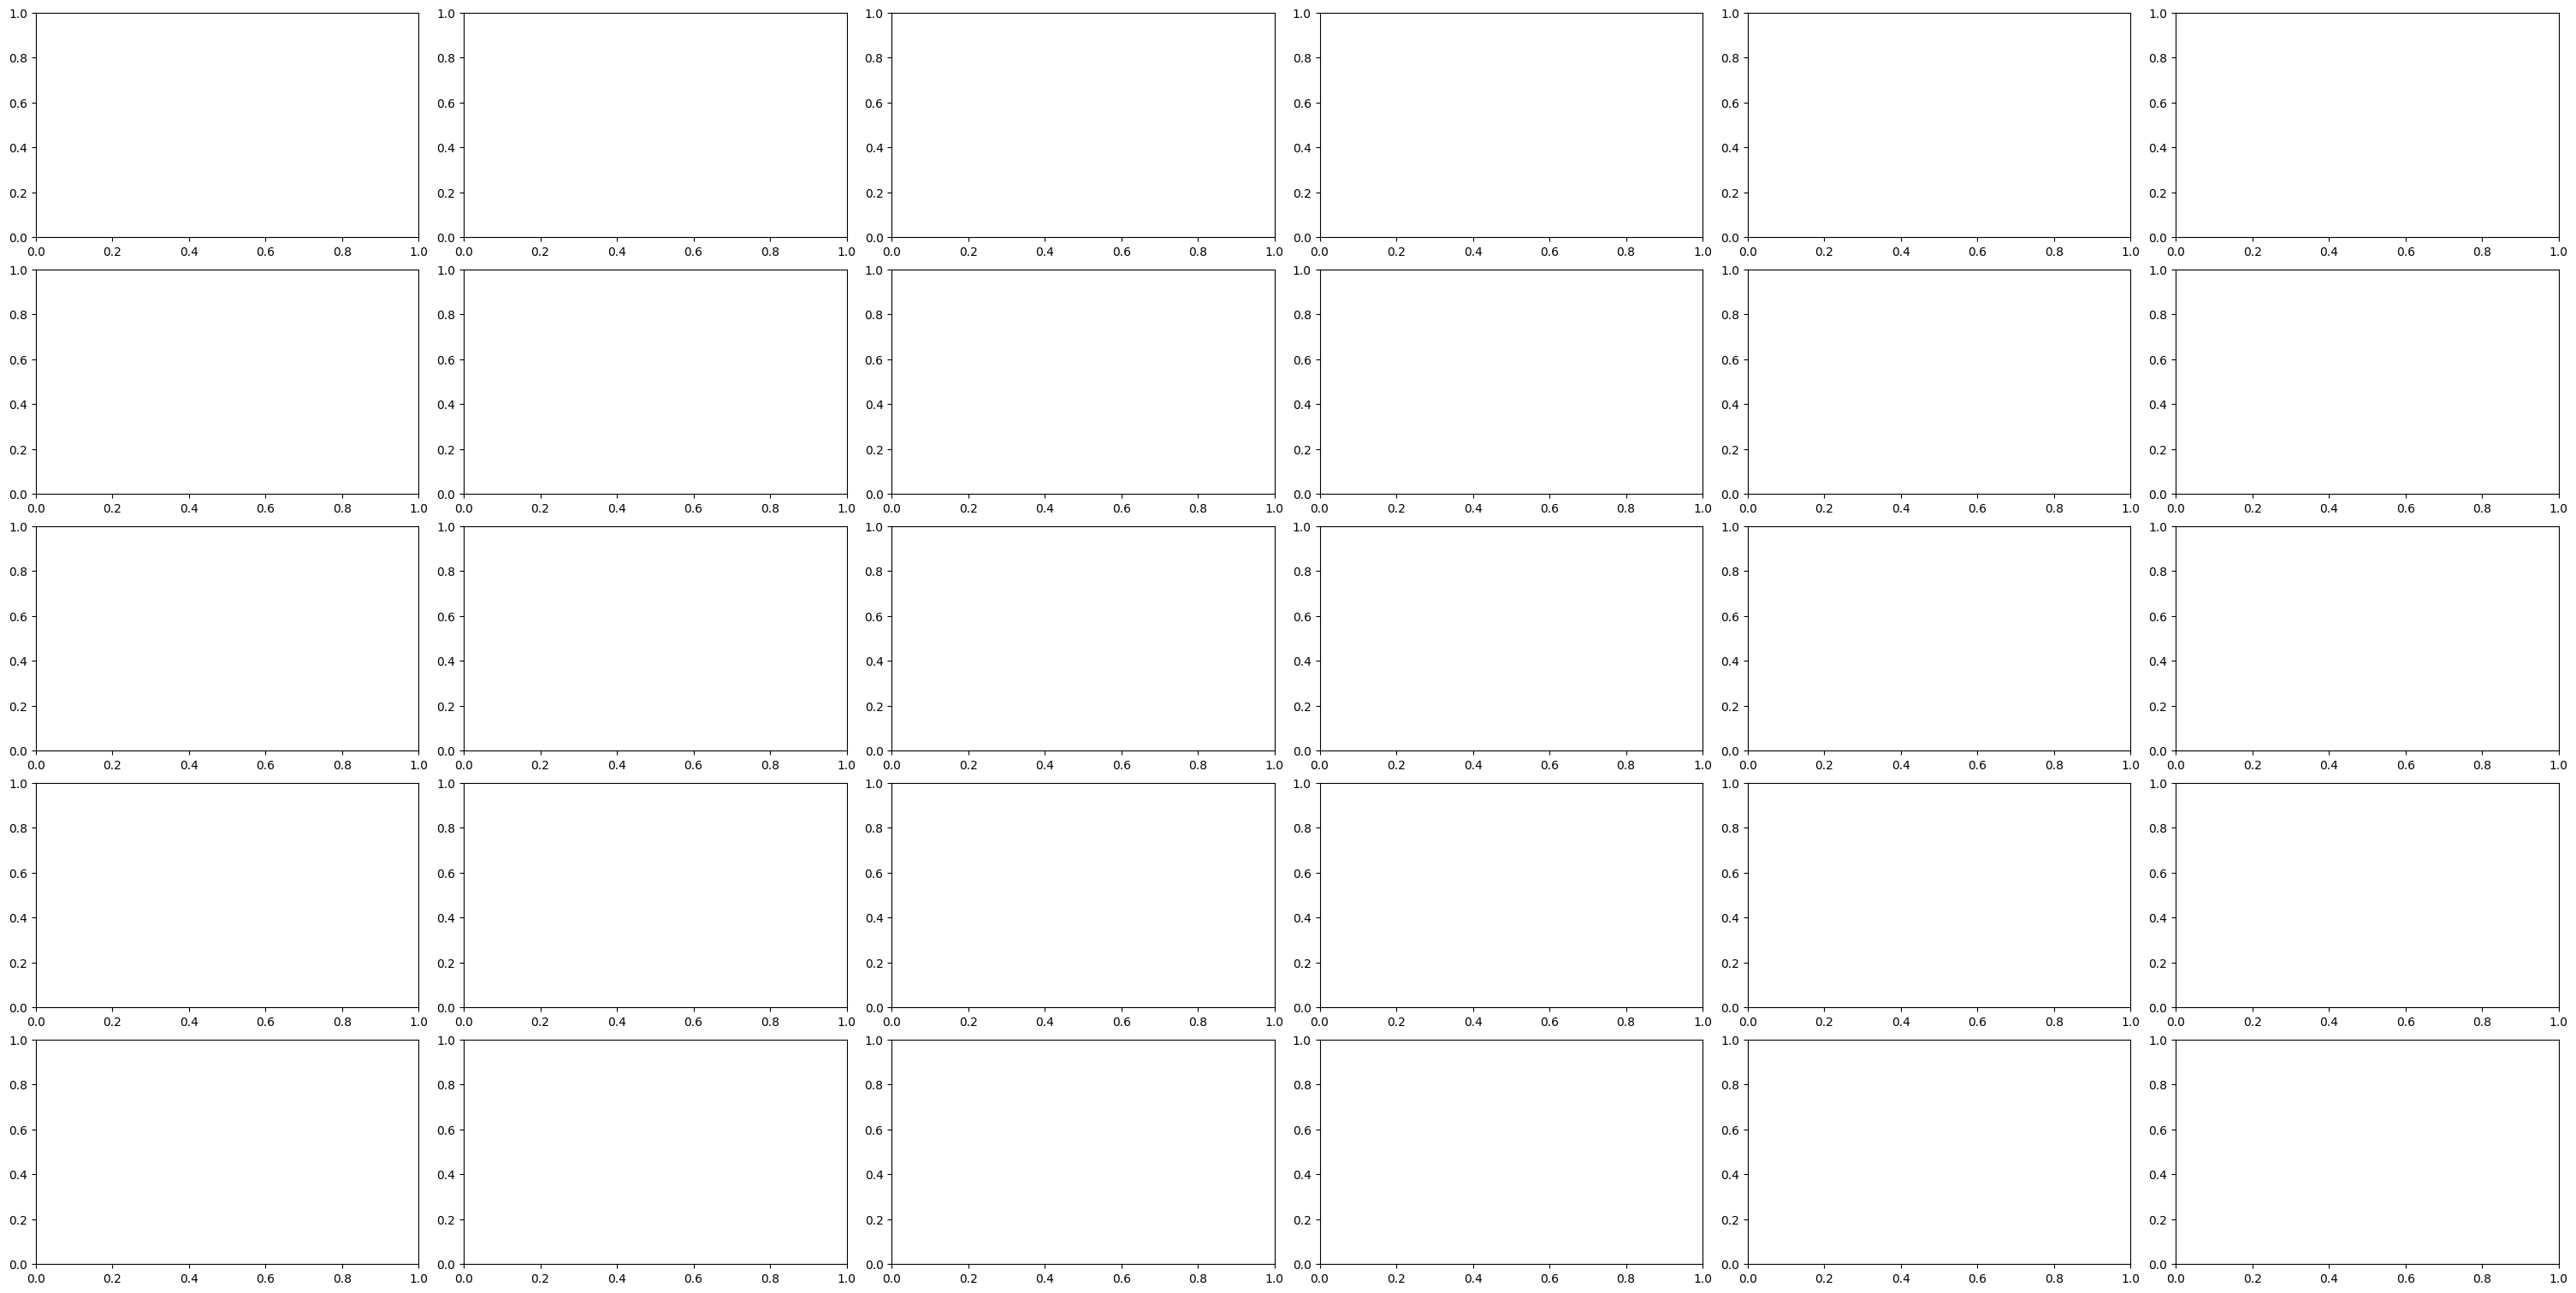

In [ ]:
model.render_recruitment_curves(df=df, encoder_dict=encoder_dict, posterior_samples=posterior_samples)


In [ ]:
model.render_predictive_check(df=df, encoder_dict=encoder_dict, posterior_samples=posterior_samples)


2023-07-18 13:06:40,802 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-07-18 13:06:56,487 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/reports/paper/simulation/run01/posterior_predictive_check.pdf
2023-07-18 13:06:56,489 - hbmep.utils.utils - INFO - func:render_predictive_check took: 15.69 sec
